In [1]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install datasets
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.5 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
     |████████████████████████████████| 6.6 MB 74.0 MB/s 
     |████████████████████████████████| 596 kB 78.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 15.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 14.3 MB/s 
     |████████████████████████████████| 212 kB 71.0 MB/s 
     |████████████████████████████████| 1.1 MB 53

In [2]:
!pip install datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul  8 02:20:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize
from torch import nn 
from transformers import AutoConfig

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout, SpatialDropout1D, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


In [5]:
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

## Loading the Dataset

In [6]:
from datasets import load_dataset

In [7]:
data = load_dataset('imdb')
del data['unsupervised']

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [9]:
data['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [10]:
data['train']['label'][1]

0

## Keras Tokenizer 
- Find the top 5000 used words
- and filter the traing and test data with only those 5000 words

In [11]:
# convert the sentences (strings) into integers
df_train = data['train']['text']
y_train = data['train']['label']
df_test = data
type(df_train)
MAX_VOCAB_SIZE=5000
tokenizerk = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True)
## Fitting only on text 
tokenizerk.fit_on_texts(df_train)

In [12]:
word_counts = tokenizerk.word_counts
sorted_word_counts = dict(sorted(word_counts.items(),key=lambda x:x[1], reverse=True))


In [13]:
from collections import defaultdict
top_5000_words = defaultdict()
for key,value in sorted_word_counts.items():
  if len(top_5000_words) > MAX_VOCAB_SIZE-1:
    break
  top_5000_words[key]=value



In [14]:
len(top_5000_words)

5000

In [15]:
def normalize(text,top_5000_words ):
    '''
    Input: list of tokens as strings,  e.g. ['I', ' ', 'saw', ' ', '@psresnik', ' ', 'on', ' ','Twitter']
    Output: list of tokens where
    All tokens are lowercased
    All tokens starting with a whitespace character have been filtered out
    All handles (tokens starting with @) have been filtered out
    Any underscores have been replaced with + (since we use _ as a special character in bigrams)
    '''
    tokenlist = text.split(' ')
    normalized_tokens = [token.lower().replace('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n','') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@") and token in top_5000_words]
    return " ".join(normalized_tokens)                      # i

In [16]:
reviews_list = data['train']['text']
review_bag = db.from_sequence(reviews_list, npartitions=3)
clean_body_train = review_bag.map(normalize,top_5000_words=top_5000_words)


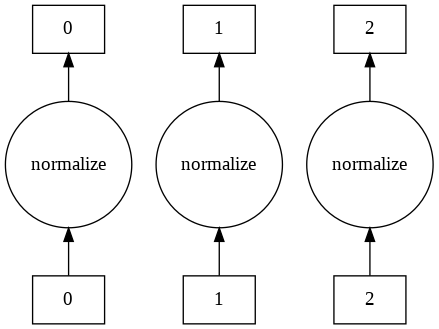

In [17]:
dask.visualize(clean_body_train)

In [18]:
more_text = clean_body_train.compute()


In [19]:
more_text[0]

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [20]:
reviews_list_test = data['test']['text']
review_bag_test = db.from_sequence(reviews_list_test, npartitions=3)
clean_body_test = review_bag_test.map(normalize,top_5000_words=top_5000_words)


In [21]:
more_text_test = clean_body_test.compute()

In [22]:
more_text_test[0]

"love and am willing to put up with a are usually and tried to like really but it is to good as 5 is to cheap cardboard stilted that doesn't match the and painfully characters cannot be overcome with a sure there are those of you out there who think 5 is good clichéd and viewers might like emotion and character is a genre that does not take itself seriously may treat important yet not as a serious really difficult to care about the characters here as they are not simply just missing a of actions and reactions are wooden and often painful to makers of it's rubbish as they have to always say otherwise people would not continue must be turning in their as this poorly edited it without breaks really brings this of a show into kill off a main then bring him back as another all over"

In [23]:
data['train'] = data['train'].add_column(name="cleaned_reviews", column=more_text)
data['test'] = data['test'].add_column(name="cleaned_reviews", column=more_text_test)

In [24]:
data['train']['cleaned_reviews'][0]

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [25]:
data['test']['cleaned_reviews'][0]

"love and am willing to put up with a are usually and tried to like really but it is to good as 5 is to cheap cardboard stilted that doesn't match the and painfully characters cannot be overcome with a sure there are those of you out there who think 5 is good clichéd and viewers might like emotion and character is a genre that does not take itself seriously may treat important yet not as a serious really difficult to care about the characters here as they are not simply just missing a of actions and reactions are wooden and often painful to makers of it's rubbish as they have to always say otherwise people would not continue must be turning in their as this poorly edited it without breaks really brings this of a show into kill off a main then bring him back as another all over"

In [26]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_reviews'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_reviews'],
        num_rows: 25000
    })
})

## Tokenizing

In [27]:
from transformers import AutoTokenizer

In [28]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [29]:
def tokenize_fn(batch):
  return tokenizer(batch['cleaned_reviews'], truncation=True,padding=True,max_length=512) #no padding option since it will be handled by the trainer in thsi case
tokenized_dataset = data.map(tokenize_fn, batched=True)

Parameter 'function'=<function tokenize_fn at 0x7f378ae2a710> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [30]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

## Embeddings Last Hidden State (features)
- These Embeddings will be common to all architecture

In [31]:
from transformers import AutoModel
checkpoint = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(checkpoint).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract Last Hidden State 
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  #Return Vector for [CLS] token
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}


In [33]:
tokenized_dataset.set_format("torch", columns=['input_ids', 'attention_mask','label'])

In [34]:
tokenized_hidden_states = tokenized_dataset.map(extract_hidden_states, batched=True, batch_size=16)

  0%|          | 0/1563 [00:00<?, ?ba/s]

  0%|          | 0/1563 [00:00<?, ?ba/s]

In [35]:
tokenized_hidden_states['train']['hidden_state'].shape

torch.Size([25000, 768])

In [36]:
tokenized_hidden_states['test']['hidden_state'].shape

torch.Size([25000, 768])

## Train and Test Data 

In [37]:
X_train = np.array(tokenized_hidden_states['train']["hidden_state"])
y_train = np.array(tokenized_hidden_states['train']["label"])
X_valid = np.array(tokenized_hidden_states['test']["hidden_state"])
y_valid = np.array(tokenized_hidden_states['test']["label"])

## DistilBERT Embeddings + Logistic Regression

#### Logistic Regression Model 

In [38]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=3000)
lr.fit(X_train,y_train)
preds = lr.predict(X_valid)

#### Performance Metric

In [39]:
cm = confusion_matrix(y_valid, preds, labels=[0, 1])

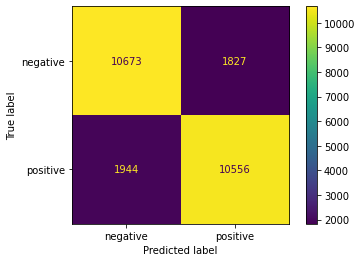

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [41]:
print(classification_report(y_valid,preds))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



## DistilBERT Embeddings + ANN Head 

#### Model Architecture for ANN

In [42]:
model = Sequential()
model.add(Dense(768, activation='relu', kernel_initializer='normal', input_shape=(768,)))
#model.add(Dropout(0.2))
model.add(Dense(600,kernel_initializer='normal', activation='relu'))
model.add(Dense(600,kernel_initializer='normal', activation='relu'))
#model.add(Dense(19,kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 768)               590592    
                                                                 
 dense_1 (Dense)             (None, 600)               461400    
                                                                 
 dense_2 (Dense)             (None, 600)               360600    
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1)                 601       
                                                                 
Total params: 1,415,593
Trainable params: 1,414,393
Non-trainable params: 1,200
__________________________________________

In [43]:
model.compile(
  loss=tf.keras.losses.binary_crossentropy,
  optimizer=tf.keras.optimizers.Adam(lr=0.001),
  metrics=['accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 768)               590592    
                                                                 
 dense_1 (Dense)             (None, 600)               461400    
                                                                 
 dense_2 (Dense)             (None, 600)               360600    
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 1)                 601       
                                                                 
Total params: 1,415,593
Trainable params: 1,414,393
Non-trainable params: 1,200
__________________________________________

In [44]:
X_train.shape

(25000, 768)

#### Model Training 

In [45]:
r = model.fit(X_train,
        y_train,
        batch_size=128,
  epochs=40,
  validation_data=(X_valid, y_valid)
)  

Epoch 1/40
196/196 [==============================] - 5s 7ms/step - loss: 0.4042 - accuracy: 0.8193 - val_loss: 0.4969 - val_accuracy: 0.7706
Epoch 2/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3754 - accuracy: 0.8351 - val_loss: 0.6199 - val_accuracy: 0.7157
Epoch 3/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3663 - accuracy: 0.8394 - val_loss: 0.4150 - val_accuracy: 0.8168
Epoch 4/40
196/196 [==============================] - 1s 5ms/step - loss: 0.3610 - accuracy: 0.8420 - val_loss: 0.5497 - val_accuracy: 0.7591
Epoch 5/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3587 - accuracy: 0.8421 - val_loss: 0.8212 - val_accuracy: 0.6752
Epoch 6/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3597 - accuracy: 0.8420 - val_loss: 0.3573 - val_accuracy: 0.8441
Epoch 7/40
196/196 [==============================] - 1s 6ms/step - loss: 0.3554 - accuracy: 0.8427 - val_loss: 0.3600 - val_accuracy: 0.8416
Epoch 

#### Model Validation

In [46]:
preds_ann = model.predict(X_valid)

In [47]:
y_valid.shape

(25000,)

In [48]:
preds_ann = np.where(preds_ann>0.5,1,0).reshape(y_valid.shape)

In [49]:
preds_ann

array([0, 0, 0, ..., 0, 0, 1])

In [50]:
cm = confusion_matrix(y_valid, preds_ann, labels=[0, 1])

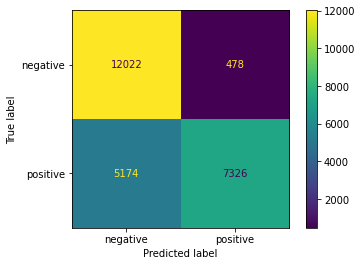

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [52]:
print(classification_report(y_valid,preds_ann))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81     12500
           1       0.94      0.59      0.72     12500

    accuracy                           0.77     25000
   macro avg       0.82      0.77      0.77     25000
weighted avg       0.82      0.77      0.77     25000



## DistilBERT Embeddings + CNN Model Concatenation

In [53]:
from transformers import AutoConfig

#### Preparing the inputs for CNN

In [54]:
X_train_cnn = X_train.reshape(25000,768,1)
X_test_cnn = X_valid.reshape(25000,768,1)

In [55]:
X_train_cnn.shape

(25000, 768, 1)

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout, SpatialDropout1D, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

##SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF


#### Model Architecture for CNN (using concatenation of CNN Layers)

In [57]:
input_ = Input(shape=(768,1))


conv1 = Conv1D(256, 20,strides=1, activation='relu')(input_)
maxp_1 = GlobalMaxPool1D(name='maxp_1')(conv1)

conv2= Conv1D(256, 10, activation='relu' )(input_)
maxp_2 = GlobalMaxPool1D(name='maxp_2')(conv2)

conv3= Conv1D(256, 5, activation='relu' )(input_)
maxp_3 = GlobalMaxPool1D(name='maxp_3')(conv3)

concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(64, activation='relu', name='dense')(concat)


output = Dense(1, activation="sigmoid")(dense_layer)
#output = dense(dense_layer)
model = Model(input_, output)



In [58]:
model.compile(
  loss=tf.keras.losses.binary_crossentropy,
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  metrics=['accuracy']
)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 749, 256)     5376        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 759, 256)     2816        ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 764, 256)     1536        ['input_1[0][0]']                
                                                                                              

In [59]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

#### Model Training 

In [60]:
r = model.fit(X_train_cnn,
        y_train,
        batch_size=64,
  epochs=10,
  callbacks=callbacks,
  validation_data=(X_test_cnn, y_valid)
)  

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6157
Epoch 1: val_loss improved from inf to 0.66071, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5
391/391 [==============================] - 16s 17ms/step - loss: 0.6769 - accuracy: 0.6159 - val_loss: 0.6607 - val_accuracy: 0.6723
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.6928
Epoch 2: val_loss improved from 0.66071 to 0.61759, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5
391/391 [==============================] - 5s 14ms/step - loss: 0.6402 - accuracy: 0.6928 - val_loss: 0.6176 - val_accuracy: 0.7110
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.5932 - accuracy: 0.7283
Epoch 3: val_loss improved from 0.61759 to 0.57512, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5
391/391 [==============================] - 5s 14ms/step - loss: 0.5932 - accuracy: 0.728

#### Model Accuracy

In [61]:
from tensorflow.keras.models import load_model
cnn = load_model('/content/drive/MyDrive/UMD/MSML612_assignment2/sw.h5')


In [64]:
preds_cnn= cnn.predict(X_valid)

In [65]:
preds_cnn = np.where(preds_cnn>0.5,1,0).reshape(y_valid.shape)

In [66]:
cm = confusion_matrix(y_valid, preds_cnn, labels=[0, 1])

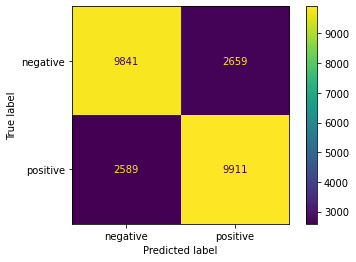

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [68]:
print(classification_report(y_valid,preds_cnn))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     12500
           1       0.79      0.79      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



## DistilBERT Embedding + CNN Suquential 

#### Model Architecture 

In [69]:
input_ = Input(shape=(768,1))


conv1 = Conv1D(256, 20,strides=1, activation='relu')(input_)
maxp_1 = GlobalMaxPool1D(name='maxp_1')(conv1)

conv2= Conv1D(128, 10, activation='relu' )(conv1)
maxp_2 = GlobalMaxPool1D(name='maxp_2')(conv2)

#conv3= Conv1D(256, 5, activation='relu' )(input_)
#maxp_3 = GlobalMaxPool1D(name='maxp_3')(conv3)

#concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(128, activation='relu', name='dense')(maxp_2)


output = Dense(1, activation="sigmoid")(dense_layer)
#output = dense(dense_layer)
model2_cnn = Model(input_, output)


In [70]:
model2_cnn.compile(
  loss=tf.keras.losses.binary_crossentropy,
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  metrics=['accuracy']
)
print(model2_cnn.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 749, 256)          5376      
                                                                 
 conv1d_4 (Conv1D)           (None, 740, 128)          327808    
                                                                 
 maxp_2 (GlobalMaxPooling1D)  (None, 128)              0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 349,825
Trainable params: 349,825
Non-trainab

In [71]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

#### Model Training 

In [72]:
r = model2_cnn.fit(X_train_cnn,
        y_train,
        batch_size=64,
  epochs=15,
  callbacks=callbacks,
  validation_data=(X_test_cnn, y_valid)
)  

Epoch 1/15
391/391 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.6506
Epoch 1: val_loss improved from inf to 0.55136, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5
391/391 [==============================] - 7s 15ms/step - loss: 0.6419 - accuracy: 0.6506 - val_loss: 0.5514 - val_accuracy: 0.7511
Epoch 2/15
387/391 [============================>.] - ETA: 0s - loss: 0.4810 - accuracy: 0.7815
Epoch 2: val_loss improved from 0.55136 to 0.45466, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5
391/391 [==============================] - 5s 14ms/step - loss: 0.4814 - accuracy: 0.7811 - val_loss: 0.4547 - val_accuracy: 0.7877
Epoch 3/15
389/391 [============================>.] - ETA: 0s - loss: 0.4267 - accuracy: 0.8050
Epoch 3: val_loss improved from 0.45466 to 0.41671, saving model to /content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5
391/391 [==============================] - 5s 14ms/step - loss: 0.4265 - accu

In [73]:
from tensorflow.keras.models import load_model
cnn2 = load_model('/content/drive/MyDrive/UMD/MSML612_assignment2/sw_seq.h5')



#### Model Metrics

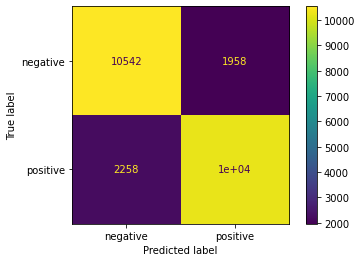

In [74]:
preds_cnn2 = cnn2.predict(X_valid)
preds_cnn2 = np.where(preds_cnn2>0.5,1,0).reshape(y_valid.shape)
cm = confusion_matrix(y_valid, preds_cnn2, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['negative', 'positive'])
disp.plot()
plt.grid(False)
plt.show()

In [75]:
print(classification_report(y_valid,preds_cnn2))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12500
           1       0.84      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

